In [1]:
pip install git+https://github.com/google-research/timesfm


  Cloning https://github.com/google-research/timesfm to /tmp/pip-req-build-d1itd17b
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/timesfm /tmp/pip-req-build-d1itd17b
  Resolved https://github.com/google-research/timesfm to commit 4b974eae481e07ca3ffd2ded2089a56b48181fce
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.2/440.2 kB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 8.

In [1]:
!pip install yfinance
!pip install utilsforecast


# forecast next day by one month

In [2]:
import yfinance as yf
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import timesfm
import numpy as np
import pandas as pd

In [ ]:

# Fetch historical data for Apple
ticker = 'AAPL'
data = yf.download(ticker, start="2020-01-01", end="2024-01-01")

# Select the 'Close' price as the feature for forecasting
data = data[['Close']]

# Reset index to use the date in the DataFrame
data.reset_index(inplace=True)

# Rename columns to match expected format
data.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
data['unique_id'] = 'AAPL'  # Add a unique_id column

# Initialize the model
tfm = timesfm.TimesFm(
    context_len=512,  # Maximum context length
    horizon_len=1,  # Forecasting the next day
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend='gpu',  # Or 'jax'
)

# Load the pretrained model
tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

# Function to predict the next day
def predict_next_day(train_data):
    forecast_df = tfm.forecast_on_df(
        inputs=train_data,
        freq="D",
        value_name="y",
        num_jobs=-1,
    )
    print('forecast_df.iloc[-1]',forecast_df)
    return forecast_df.iloc[-1]['timesfm']

# Splitting the data into rolling windows
start_date = '2023-01-01'
end_date = '2023-12-31'
window_size = 30

results = []

date_range = pd.date_range(start=start_date, end=end_date)

for i in range(len(date_range) - window_size):
    train_window_start = date_range[i]
    train_window_end = date_range[i + window_size - 1]
    predict_date = date_range[i + window_size]
    print('train_window_start',train_window_start,'train_window_end',train_window_end,'predict_date',predict_date)

    train_data = data[(data['ds'] >= train_window_start) & (data['ds'] <= train_window_end)]
    print('train_data',train_data)
    if predict_date not in data['ds'].values:
      print(f"Skipping prediction for {predict_date} as it's not in the data.")
      continue

    actual_value = data[data['ds'] == predict_date]['y'].values


    predicted_value = predict_next_day(train_data)
    results.append({'ds': predict_date, 'y_actual': actual_value[0], 'y_predicted': predicted_value})



In [ ]:
len(results)

In [ ]:


# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save DataFrame to CSV file
results_df.to_csv('one_month_input_one_dY.csv', index=False)

print("Results saved to prediction_results.csv")


Results saved to prediction_results.csv


In [4]:
results_df=pd.read_csv('/content/one_month_input_one_dY.csv',)
results_df

,ds,y_actual,y_predicted
0,2023-01-31,144.289993,140.42755
1,2023-02-01,145.429993,143.24666
2,2023-02-02,150.820007,145.26890
3,2023-02-03,154.500000,149.06754
4,2023-02-06,151.729996,153.91434
...,...,...,...
226,2023-12-22,193.600006,193.98984
227,2023-12-26,193.050003,193.25229
228,2023-12-27,193.149994,192.46585
229,2023-12-28,193.580002,192.46298


MSE for the predictive model: 7.127781104585507
MSE for the naive prediction: 4.608868222595602


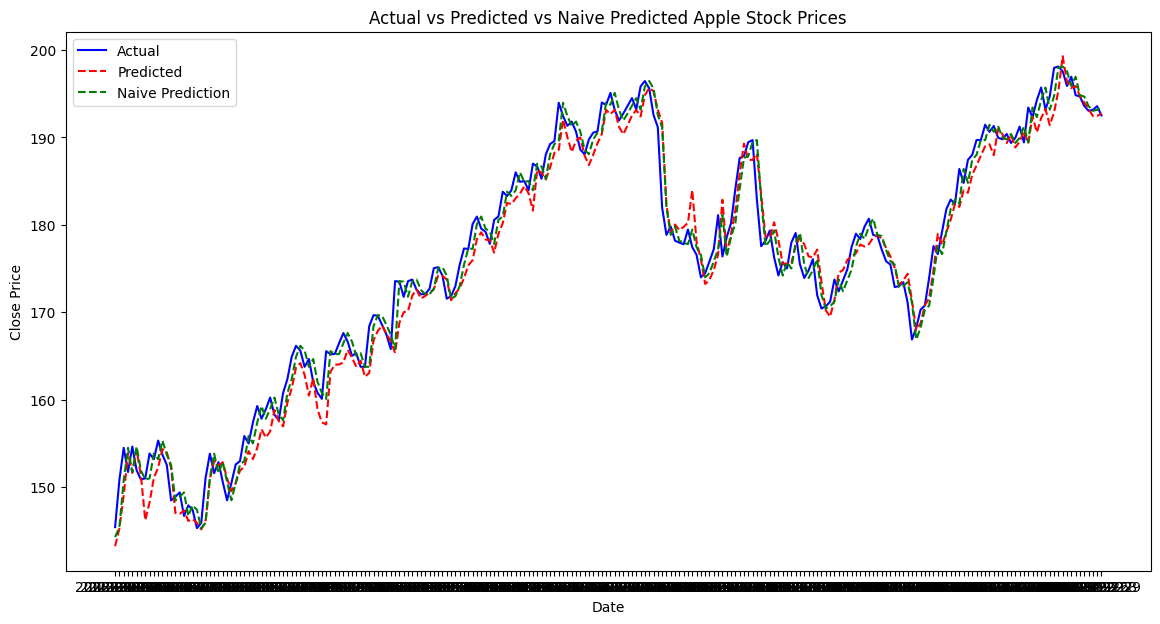

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


mse_model = mean_squared_error(results_df['y_actual'], results_df['y_predicted'])
print(f'MSE for the predictive model: {mse_model}')

# محاسبه MSE برای پیش‌بینی ناهموار (فرض می‌کنیم قیمت فردا برابر با قیمت امروز است)
results_df['y_naive'] = results_df['y_actual'].shift(1)  # قیمت ناهموار
results_df.dropna(inplace=True)


mse_naive = mean_squared_error(results_df['y_actual'], results_df['y_naive'])
print(f'MSE for the naive prediction: {mse_naive}')

# رسم نمودار مقایسه‌ای
plt.figure(figsize=(14, 7))
plt.plot(results_df['ds'], results_df['y_actual'], label='Actual', color='blue')
plt.plot(results_df['ds'], results_df['y_predicted'], label='Predicted', color='red', linestyle='--')
plt.plot(results_df['ds'], results_df['y_naive'], label='Naive Prediction', color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted vs Naive Predicted Apple Stock Prices')
plt.legend()
plt.show()


In [7]:
import pandas as pd



# Initialize variables for accuracy calculation
correct_predictions = 0
total_predictions = 0

# Iterate through each row in the DataFrame
for i in range(1, len(results_df)):
    # Get actual and predicted prices for the current and previous days
    actual_today = results_df.iloc[i]['y_actual']
    predicted_today = results_df.iloc[i]['y_predicted']
    actual_yesterday_index = i - 1
    actual_yesterday_date = results_df.iloc[actual_yesterday_index]['ds']

    # Check if the date of the previous row is the previous day of the current row
    if pd.to_datetime(actual_yesterday_date) != pd.to_datetime(results_df.iloc[i]['ds']) - pd.DateOffset(days=1):
        continue  # Skip this row if the previous date is not the previous day

    actual_yesterday = results_df.iloc[actual_yesterday_index]['y_actual']

    # Calculate actual and predicted movements
    actual_movement = actual_today - actual_yesterday
    predicted_movement = predicted_today - actual_yesterday  # We use yesterday's actual price as reference

    # Check if the directions of actual and predicted movements match
    if (actual_movement > 0 and predicted_movement > 0) or (actual_movement < 0 and predicted_movement < 0):
        correct_predictions += 1

    total_predictions += 1

# Calculate accuracy
accuracy = correct_predictions / total_predictions
print("Accuracy based on price movements:", accuracy)


Accuracy based on price movements: 0.4388888888888889


In [ ]:
total_predictions

180

In [ ]:
results_df

,ds,y_actual,y_predicted,y_naive,signal
1,2023-02-01,145.429993,143.24666,144.289993,Buy
2,2023-02-02,150.820007,145.26890,145.429993,Buy
3,2023-02-03,154.500000,149.06754,150.820007,Buy
4,2023-02-06,151.729996,153.91434,154.500000,Sell
5,2023-02-07,154.649994,151.62733,151.729996,Buy
...,...,...,...,...,...
226,2023-12-22,193.600006,193.98984,194.679993,Sell
227,2023-12-26,193.050003,193.25229,193.600006,Sell
228,2023-12-27,193.149994,192.46585,193.050003,Sell
229,2023-12-28,193.580002,192.46298,193.149994,Buy


# buy and sell all

Total Profit: 25.80 USD
             ds    y_actual  y_predicted signal     capital
1    2023-02-01  145.429993    143.24666    Buy  100.000000
2    2023-02-02  150.820007    145.26890    Buy  101.853130
3    2023-02-03  154.500000    149.06754    Buy  103.728339
4    2023-02-06  151.729996    153.91434   Sell  102.092721
5    2023-02-07  154.649994    151.62733    Buy  102.954814
..          ...         ...          ...    ...         ...
226  2023-12-22  193.600006    193.98984   Sell  121.563644
227  2023-12-26  193.050003    193.25229   Sell  121.537301
228  2023-12-27  193.149994    192.46585   Sell  121.539696
229  2023-12-28  193.580002    192.46298    Buy  121.544844
230  2023-12-29  192.529999    192.72406   Sell  121.208921

[230 rows x 5 columns]


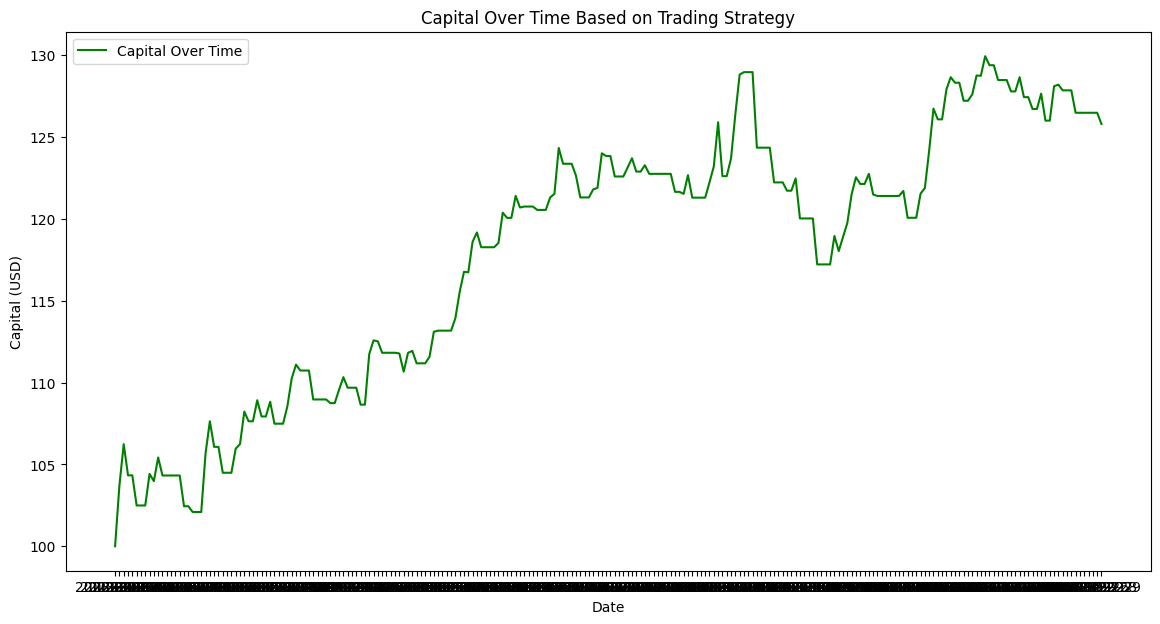

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# ایجاد سیگنال‌های خرید و فروش
results_df['signal'] = np.where(results_df['y_predicted'].shift(-1) > results_df['y_predicted'], 'Buy', 'Sell')

# تنظیمات اولیه سرمایه
initial_investment = 100  # سرمایه اولیه
capital = initial_investment  # سرمایه اولیه
shares = 0  # تعداد سهام خریداری شده
profit = 0  # سود کل

# لیستی برای ذخیره سود و سرمایه روزانه
capital_history = []
# محاسبه سود و زیان بر اساس سیگنال‌ها
for i in range(len(results_df) - 1):
    i=i+1
    if results_df.loc[i, 'signal'] == 'Buy' and capital > 0:
        # خرید سهام با تمام سرمایه
        shares = capital / results_df.loc[i, 'y_actual']

        capital = 0  # تمام سرمایه به سهام تبدیل می‌شود
    elif results_df.loc[i, 'signal'] == 'Sell' and shares > 0:

        # فروش تمام سهام و تبدیل به پول نقد
        capital = shares * results_df.loc[i, 'y_actual']
        shares = 0  # تمام سهام فروخته می‌شود
    # ذخیره سرمایه روزانه
    capital_history.append(capital + shares * results_df.loc[i, 'y_actual'])

# # محاسبه سود نهایی
final_capital = capital + shares * results_df.iloc[-1]['y_actual']
total_profit = final_capital - initial_investment

print(f'Total Profit: {total_profit:.2f} USD')

# # نمایش سیگنال‌ها و سود هر روز
results_df['buy_sell_all_capital'] = capital_history + [final_capital]
print(results_df[['ds', 'y_actual', 'y_predicted', 'signal', 'buy_sell_all_capital']])

# # رسم نمودار سود تجمعی
plt.figure(figsize=(14, 7))
plt.plot(results_df['ds'], results_df['buy_sell_all_capital'], label='Capital Over Time', color='green')
plt.xlabel('Date')
plt.ylabel('Capital (USD)')
plt.title('Capital Over Time Based on Trading Strategy')
plt.legend()
plt.show()


# y_naive

Total Profit: 19.88 USD
             ds    y_actual  y_predicted signal     capital
1    2023-02-01  145.429993    143.24666    Buy  100.000000
2    2023-02-02  150.820007    145.26890    Buy  101.853130
3    2023-02-03  154.500000    149.06754    Buy  103.728339
4    2023-02-06  151.729996    153.91434   Sell  102.092721
5    2023-02-07  154.649994    151.62733    Buy  102.954814
..          ...         ...          ...    ...         ...
226  2023-12-22  193.600006    193.98984   Sell  121.563644
227  2023-12-26  193.050003    193.25229   Sell  121.537301
228  2023-12-27  193.149994    192.46585    Buy  121.539696
229  2023-12-28  193.580002    192.46298    Buy  121.544844
230  2023-12-29  192.529999    192.72406   Sell  121.208921

[230 rows x 5 columns]


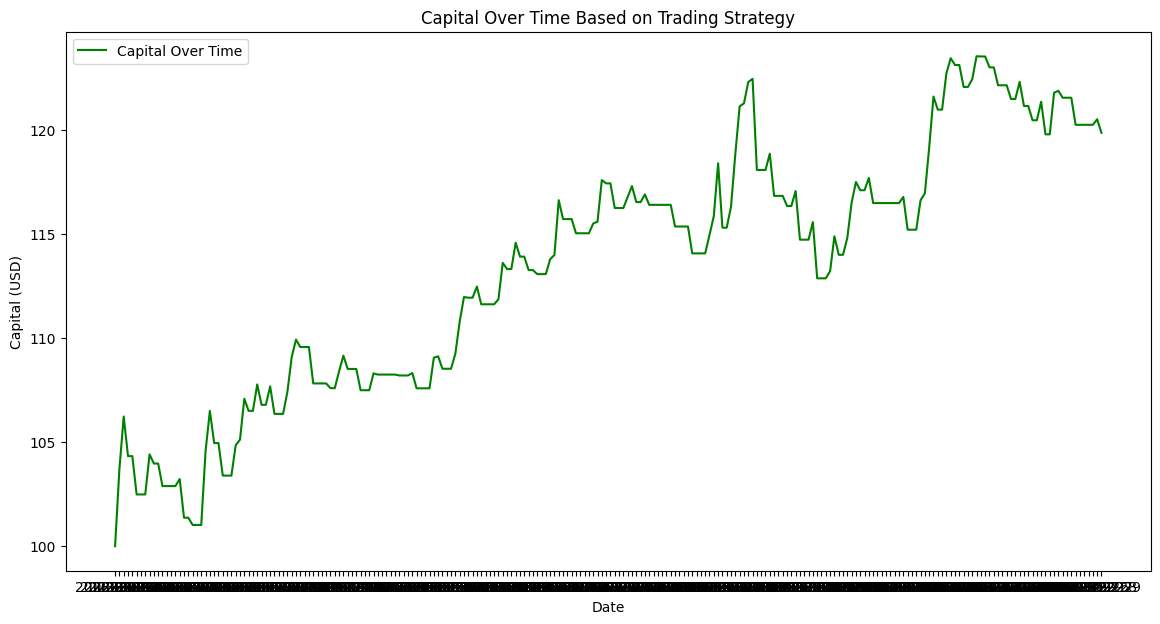

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# ایجاد سیگنال‌های خرید و فروش
results_df['signal'] = np.where(results_df['y_naive'].shift(-1) > results_df['y_naive'], 'Buy', 'Sell')

# تنظیمات اولیه سرمایه
initial_investment = 100  # سرمایه اولیه
capital = initial_investment  # سرمایه اولیه
shares = 0  # تعداد سهام خریداری شده
profit = 0  # سود کل

# لیستی برای ذخیره سود و سرمایه روزانه
capital_history = []


# محاسبه سود و زیان بر اساس سیگنال‌ها
for i in range(len(results_df) - 1):
    i=i+1
    if results_df.loc[i, 'signal'] == 'Buy' and capital > 0:
        # خرید سهام با تمام سرمایه
        shares = capital / results_df.loc[i, 'y_actual']

        capital = 0  # تمام سرمایه به سهام تبدیل می‌شود
    elif results_df.loc[i, 'signal'] == 'Sell' and shares > 0:

        # فروش تمام سهام و تبدیل به پول نقد
        capital = shares * results_df.loc[i, 'y_actual']
        shares = 0  # تمام سهام فروخته می‌شود
    # ذخیره سرمایه روزانه
    capital_history.append(capital + shares * results_df.loc[i, 'y_actual'])

# # محاسبه سود نهایی
final_capital = capital + shares * results_df.iloc[-1]['y_actual']
total_profit = final_capital - initial_investment

print(f'Total Profit: {total_profit:.2f} USD')

# # نمایش سیگنال‌ها و سود هر روز
results_df['naive_capital'] = capital_history + [final_capital]
print(results_df[['ds', 'y_actual', 'y_predicted', 'signal', 'capital']])

# # رسم نمودار سود تجمعی
plt.figure(figsize=(14, 7))
plt.plot(results_df['ds'], results_df['naive_capital'], label='Capital Over Time', color='green')
plt.xlabel('Date')
plt.ylabel('Capital (USD)')
plt.title('Capital Over Time Based on Trading Strategy')
plt.legend()
plt.show()


# buy_and_hold_profit

In [16]:
initial_investment = 100
buy_and_hold_final_value = initial_investment * (results_df['y_actual'].iloc[-1] / results_df['y_actual'].iloc[0])
buy_and_hold_profit = buy_and_hold_final_value - initial_investment
buy_and_hold_profit

32.38672108615137

# buy with fraction sell all

Total Profit: 18.81 USD
             ds    y_actual  y_predicted signal     capital
1    2023-02-01  145.429993    143.24666    Buy  100.000000
2    2023-02-02  150.820007    145.26890    Buy  101.853130
3    2023-02-03  154.500000    149.06754    Buy  103.728339
4    2023-02-06  151.729996    153.91434   Sell  102.092721
5    2023-02-07  154.649994    151.62733    Buy  102.954814
..          ...         ...          ...    ...         ...
226  2023-12-22  193.600006    193.98984   Sell  121.563644
227  2023-12-26  193.050003    193.25229   Sell  121.537301
228  2023-12-27  193.149994    192.46585   Sell  121.539696
229  2023-12-28  193.580002    192.46298    Buy  121.544844
230  2023-12-29  192.529999    192.72406   Sell  121.208921

[230 rows x 5 columns]


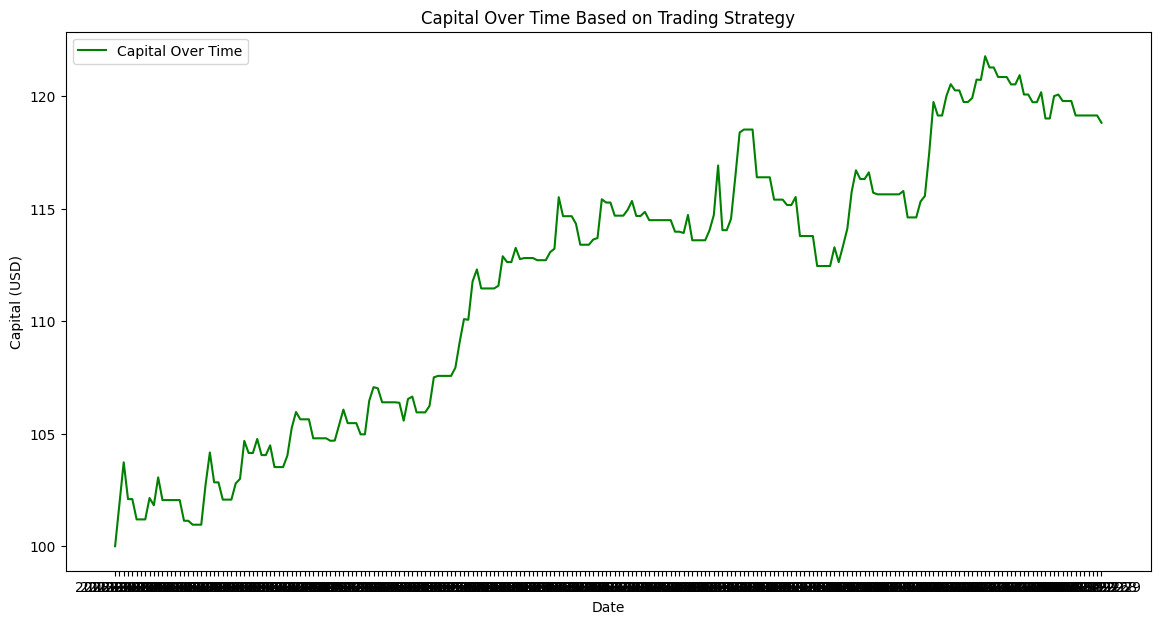

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# ایجاد سیگنال‌های خرید و فروش
results_df['signal'] = np.where(results_df['y_predicted'].shift(-1) > results_df['y_predicted'], 'Buy', 'Sell')

# تنظیمات اولیه سرمایه
initial_investment = 100  # سرمایه اولیه
capital = initial_investment  # سرمایه اولیه
shares = 0  # تعداد سهام خریداری شده
profit = 0  # سود کل
trading_fraction = 0.5

# لیستی برای ذخیره سود و سرمایه روزانه
capital_history = []
# محاسبه سود و زیان بر اساس سیگنال‌ها
for i in range(len(results_df) - 1):
    i=i+1
    if results_df.loc[i, 'signal'] == 'Buy' and capital > 0:
        investment_amount = capital * trading_fraction
        shares_bought = investment_amount / results_df.loc[i, 'y_actual']
        shares += shares_bought
        capital -= investment_amount
    elif results_df.loc[i, 'signal'] == 'Sell' and shares > 0:

        shares_sold = shares
        capital += shares_sold * results_df.loc[i, 'y_actual']
        shares -= shares_sold
    # ذخیره سرمایه روزانه
    capital_history.append(capital + shares * results_df.loc[i, 'y_actual'])

# # محاسبه سود نهایی
final_capital = capital + shares * results_df.iloc[-1]['y_actual']
total_profit = final_capital - initial_investment

print(f'Total Profit: {total_profit:.2f} USD')

# # نمایش سیگنال‌ها و سود هر روز
results_df['buy_fraction_sell_all_capital'] = capital_history + [final_capital]
print(results_df[['ds', 'y_actual', 'y_predicted', 'signal', 'capital']])

# # رسم نمودار سود تجمعی
plt.figure(figsize=(14, 7))
plt.plot(results_df['ds'], results_df['buy_fraction_sell_all_capital'], label='Capital Over Time', color='green')
plt.xlabel('Date')
plt.ylabel('Capital (USD)')
plt.title('Capital Over Time Based on Trading Strategy')
plt.legend()
plt.show()


# buy and sell with fraction

Total Profit: 21.21 USD
             ds    y_actual  y_predicted signal     capital
1    2023-02-01  145.429993    143.24666    Buy  100.000000
2    2023-02-02  150.820007    145.26890    Buy  101.853130
3    2023-02-03  154.500000    149.06754    Buy  103.728339
4    2023-02-06  151.729996    153.91434   Sell  102.092721
5    2023-02-07  154.649994    151.62733    Buy  102.954814
..          ...         ...          ...    ...         ...
226  2023-12-22  193.600006    193.98984   Sell  121.563644
227  2023-12-26  193.050003    193.25229   Sell  121.537301
228  2023-12-27  193.149994    192.46585   Sell  121.539696
229  2023-12-28  193.580002    192.46298    Buy  121.544844
230  2023-12-29  192.529999    192.72406   Sell  121.208921

[230 rows x 5 columns]


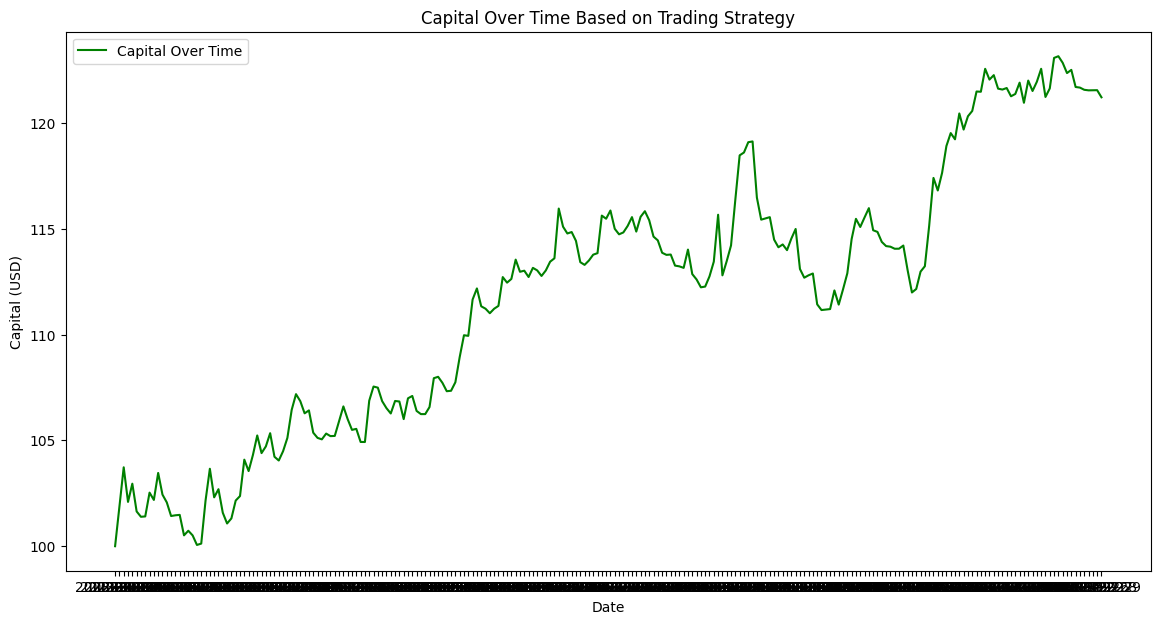

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# ایجاد سیگنال‌های خرید و فروش
results_df['signal'] = np.where(results_df['y_predicted'].shift(-1) > results_df['y_predicted'], 'Buy', 'Sell')

# تنظیمات اولیه سرمایه
initial_investment = 100  # سرمایه اولیه
capital = initial_investment  # سرمایه اولیه
shares = 0  # تعداد سهام خریداری شده
profit = 0  # سود کل
trading_fraction = 0.5

# لیستی برای ذخیره سود و سرمایه روزانه
capital_history = []
# محاسبه سود و زیان بر اساس سیگنال‌ها
for i in range(len(results_df) - 1):
    i=i+1
    if results_df.loc[i, 'signal'] == 'Buy' and capital > 0:
        investment_amount = capital * trading_fraction
        shares_bought = investment_amount / results_df.loc[i, 'y_actual']
        shares += shares_bought
        capital -= investment_amount
    elif results_df.loc[i, 'signal'] == 'Sell' and shares > 0:

        shares_sold = shares * trading_fraction
        capital += shares_sold * results_df.loc[i, 'y_actual']
        shares -= shares_sold
    # ذخیره سرمایه روزانه
    capital_history.append(capital + shares * results_df.loc[i, 'y_actual'])

# # محاسبه سود نهایی
final_capital = capital + shares * results_df.iloc[-1]['y_actual']
total_profit = final_capital - initial_investment

print(f'Total Profit: {total_profit:.2f} USD')

# # نمایش سیگنال‌ها و سود هر روز
results_df['buy_sell_fraction_capital'] = capital_history + [final_capital]
print(results_df[['ds', 'y_actual', 'y_predicted', 'signal', 'capital']])

# # رسم نمودار سود تجمعی
plt.figure(figsize=(14, 7))
plt.plot(results_df['ds'], results_df['buy_sell_fraction_capital'], label='Capital Over Time', color='green')
plt.xlabel('Date')
plt.ylabel('Capital (USD)')
plt.title('Capital Over Time Based on Trading Strategy')
plt.legend()
plt.show()


# all in one

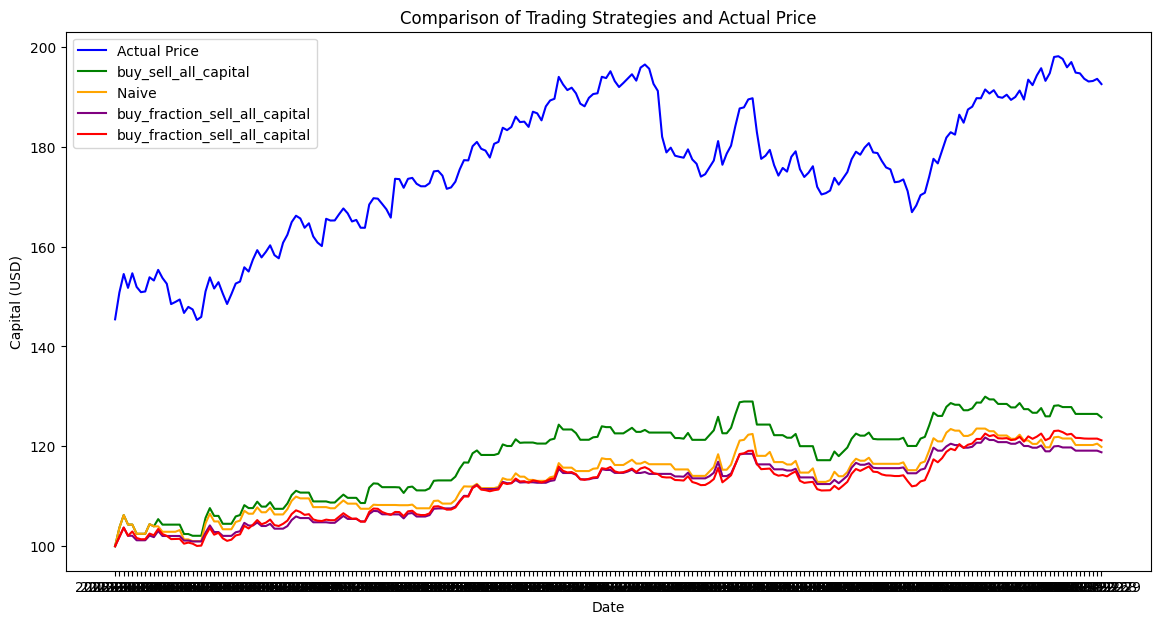

In [37]:
plt.figure(figsize=(14, 7))


plt.plot(results_df['ds'], results_df['y_actual'], label='Actual Price', color='blue')


plt.plot(results_df['ds'], results_df['buy_sell_all_capital'], label='buy_sell_all_capital', color='green')


plt.plot(results_df['ds'], results_df['naive_capital'], label='Naive ', color='orange')


plt.plot(results_df['ds'],results_df['buy_fraction_sell_all_capital'] , label='buy_fraction_sell_all_capital', color='purple')

plt.plot(results_df['ds'],results_df['buy_sell_fraction_capital'] , label='buy_fraction_sell_all_capital', color='red')

plt.xlabel('Date')
plt.ylabel('Capital (USD)')
plt.title('Comparison of Trading Strategies and Actual Price')
plt.legend()
plt.show()

Positive Predictions Error Analysis:
{'mean_absolute_error': 2.0827618957149614, 'max_absolute_error': 6.5304430517578, 'mean_squared_error': 6.657162263710276, 'max_squared_error': 42.64668645225173}
Negative Predictions Error Analysis:
{'mean_absolute_error': 2.0827945428781405, 'max_absolute_error': 9.690414506835907, 'mean_squared_error': 7.71223305812133, 'max_squared_error': 93.90413331429579}


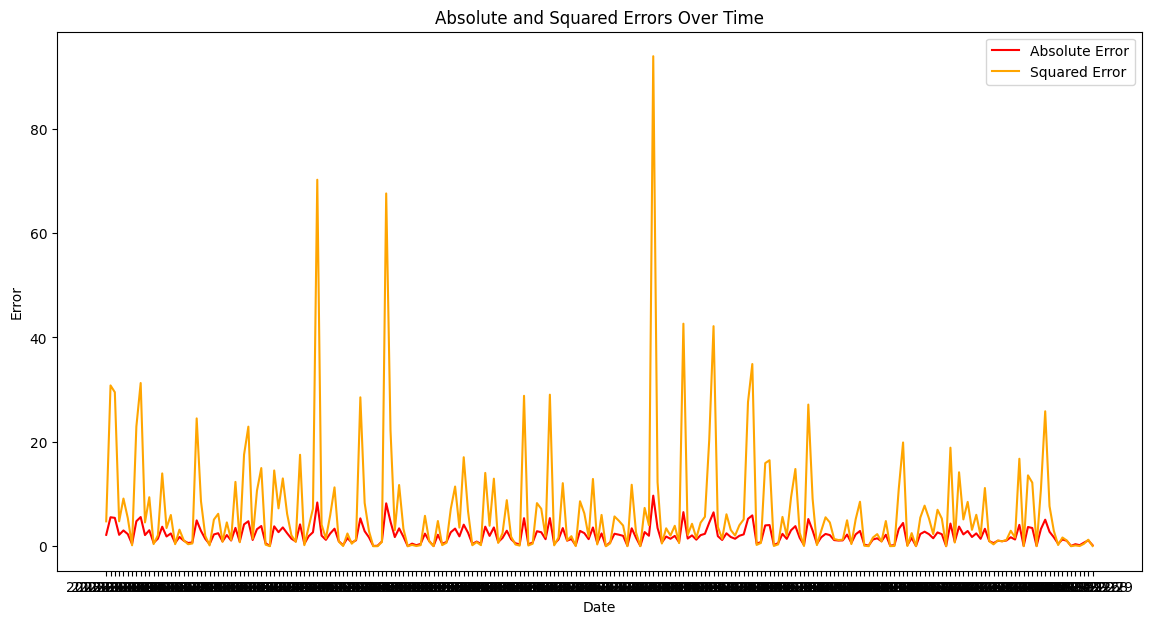

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# محاسبه خطاهای مطلق و خطای مربع
results_df['absolute_error'] = np.abs(results_df['y_actual'] - results_df['y_predicted'])
results_df['squared_error'] = (results_df['y_actual'] - results_df['y_predicted']) ** 2



# تحلیل بر اساس جهت تغییرات قیمت
results_df['direction_actual'] = np.sign(results_df['y_actual'].diff())
results_df['direction_predicted'] = np.sign(results_df['y_predicted'].diff())

positive_pred_errors = results_df[results_df['direction_predicted'] > 0]
negative_pred_errors = results_df[results_df['direction_predicted'] < 0]

positive_pred_analysis = {
    'mean_absolute_error': positive_pred_errors['absolute_error'].mean(),
    'max_absolute_error': positive_pred_errors['absolute_error'].max(),
    'mean_squared_error': positive_pred_errors['squared_error'].mean(),
    'max_squared_error': positive_pred_errors['squared_error'].max()
}

negative_pred_analysis = {
    'mean_absolute_error': negative_pred_errors['absolute_error'].mean(),
    'max_absolute_error': negative_pred_errors['absolute_error'].max(),
    'mean_squared_error': negative_pred_errors['squared_error'].mean(),
    'max_squared_error': negative_pred_errors['squared_error'].max()
}

print("Positive Predictions Error Analysis:")
print(positive_pred_analysis)

print("Negative Predictions Error Analysis:")
print(negative_pred_analysis)



# رسم نمودار خطاها
plt.figure(figsize=(14, 7))
plt.plot(results_df['ds'], results_df['absolute_error'], label='Absolute Error', color='red')
plt.plot(results_df['ds'], results_df['squared_error'], label='Squared Error', color='orange')
plt.xlabel('Date')
plt.ylabel('Error')
plt.title('Absolute and Squared Errors Over Time')
plt.legend()
plt.show()




Correct Positive Predictions: 71
Incorrect Positive Predictions: 61
Correct Negative Predictions: 44
Incorrect Negative Predictions: 53


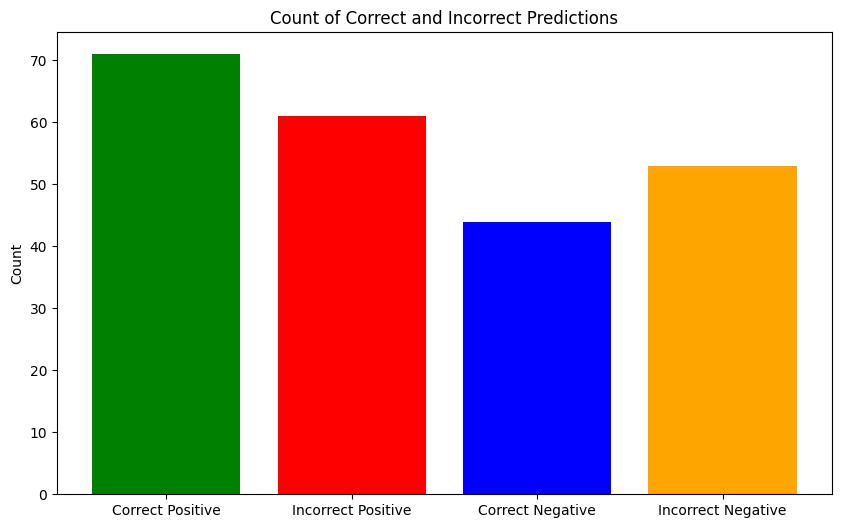

In [43]:
import numpy as np
import pandas as pd

# افزودن ستون‌های جهت پیش‌بینی شده و واقعی
results_df['direction_actual'] = np.sign(results_df['y_actual'].diff())
results_df['direction_predicted'] = np.sign(results_df['y_predicted'].diff())

# تحلیل جهت پیش‌بینی شده
results_df['correct_prediction'] = results_df['direction_actual'] == results_df['direction_predicted']

# پیش‌بینی‌های افزایش قیمت
positive_predictions = results_df[results_df['direction_predicted'] > 0]
correct_positive_predictions = positive_predictions[positive_predictions['correct_prediction']].shape[0]
incorrect_positive_predictions = positive_predictions[~positive_predictions['correct_prediction']].shape[0]

# پیش‌بینی‌های کاهش قیمت
negative_predictions = results_df[results_df['direction_predicted'] < 0]
correct_negative_predictions = negative_predictions[negative_predictions['correct_prediction']].shape[0]
incorrect_negative_predictions = negative_predictions[~negative_predictions['correct_prediction']].shape[0]

print(f'Correct Positive Predictions: {correct_positive_predictions}')
print(f'Incorrect Positive Predictions: {incorrect_positive_predictions}')
print(f'Correct Negative Predictions: {correct_negative_predictions}')
print(f'Incorrect Negative Predictions: {incorrect_negative_predictions}')

# رسم نمودار
labels = ['Correct Positive', 'Incorrect Positive', 'Correct Negative', 'Incorrect Negative']
values = [correct_positive_predictions, incorrect_positive_predictions, correct_negative_predictions, incorrect_negative_predictions]

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['green', 'red', 'blue', 'orange'])
plt.ylabel('Count')
plt.title('Count of Correct and Incorrect Predictions')
plt.show()


<ipython-input-45-cedc862f133e>:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_accuracy = results_df.groupby('price_change_bin')['correct_prediction'].mean().reset_index()


  Price Change  Accuracy
0      0.0-1.0  0.417722
1      1.0-2.0  0.537500
2      2.0-3.0  0.512195
3      3.0-4.0  0.625000
4      4.0-5.0  0.666667
5      5.0-6.0  0.750000
6      6.0-7.0  0.000000
7      7.0-8.0  0.000000
8      8.0-9.0       NaN
9     9.0-10.0  1.000000


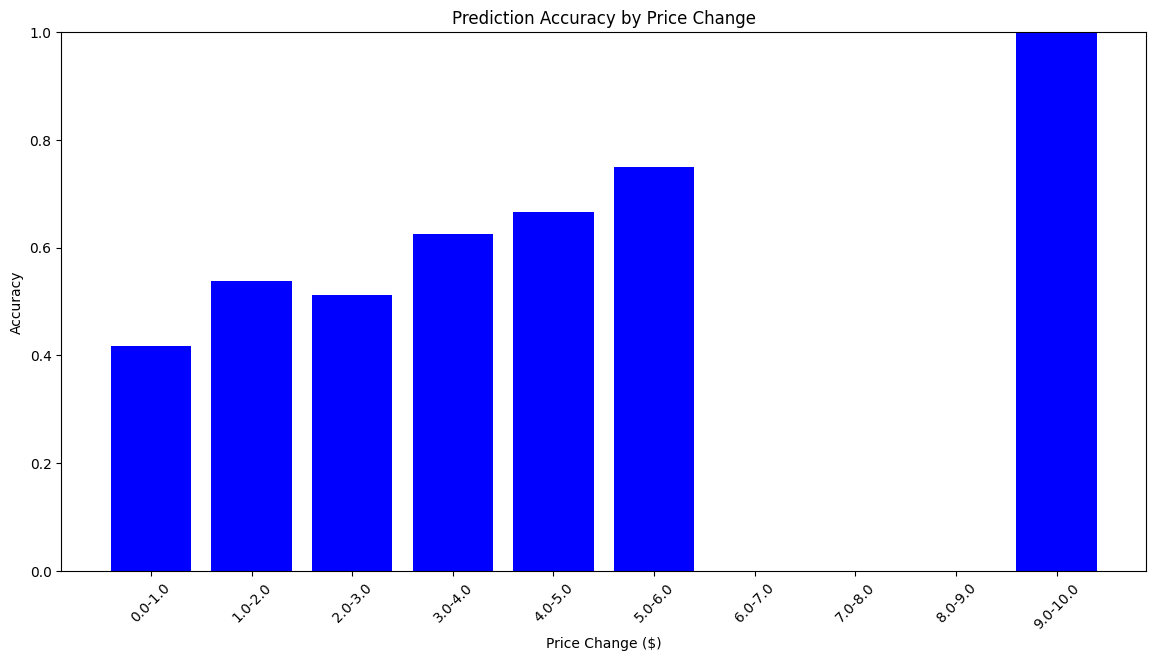

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# محاسبه تغییرات قیمت
results_df['price_change'] = results_df['y_actual'].diff().abs()

# تعریف دسته‌ها بر اساس تغییرات قیمت در بازه‌های یک دلاری
bins = np.arange(0, results_df['price_change'].max() + 1, 1)
labels = [f'{i}-{i+1}' for i in bins[:-1]]
results_df['price_change_bin'] = pd.cut(results_df['price_change'], bins=bins, labels=labels, include_lowest=True)

# محاسبه دقت پیش‌بینی برای هر دسته
results_df['correct_prediction'] = results_df['direction_actual'] == results_df['direction_predicted']
grouped_accuracy = results_df.groupby('price_change_bin')['correct_prediction'].mean().reset_index()
grouped_accuracy.columns = ['Price Change', 'Accuracy']

print(grouped_accuracy)

# رسم نمودار دقت پیش‌بینی برای هر دسته
plt.figure(figsize=(14, 7))
plt.bar(grouped_accuracy['Price Change'], grouped_accuracy['Accuracy'], color='blue')
plt.xlabel('Price Change ($)')
plt.ylabel('Accuracy')
plt.title('Prediction Accuracy by Price Change')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()
